필요한 라이브러리 임포트

In [ ]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import matplotlib.pyplot as plt
import os

1. 데이터 로딩 및 전처리
- 랜덤 크롭, 좌우 반전, 밝기 조절, 회전 등 적용으로 데이터 다양성 향상

In [ ]:
batch_size = 16
img_height = 224
img_width = 224

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness = 0.2),
    transforms.RandomRotation(degrees = (0, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.CenterCrop((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

- Dataset 클래스 정의
 - Dataset을 PyTorch Dataset 클래스로 커스텀하여 학습 및 검증에 활용 가능하도록 정의

torch.Size([16, 3, 224, 224])


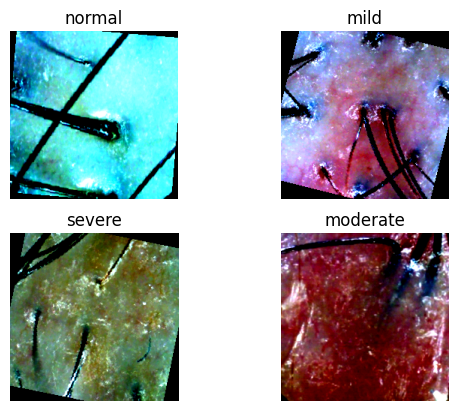

In [ ]:
class CustomImageDataset(Dataset):

    def __init__(self, img_dir, transform = None):
        self.transform = transform
        root = Path(img_dir)
        self.paths = list(root.glob('*/*'))
        self.class_name = ['normal', 'mild', 'moderate', 'severe']
        self.cindex = {'normal':0, 'mild':1, 'moderate':2, 'severe':3}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = path.parts[-2]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.cindex[label]

train_set = CustomImageDataset('./condition/training',
                                 transform = train_transforms)

val_set = CustomImageDataset('./condition/testing',
                               transform = val_transforms)

class_names = train_set.class_name

train_loader = DataLoader(train_set,
                          batch_size = batch_size,
                          shuffle = True)

val_loader = DataLoader(val_set,
                        batch_size = batch_size,
                        shuffle = False)

for feature, label in train_loader:
    print(feature.shape)
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(feature[i].permute((1, 2, 0)))
        plt.title(class_names[label[i]])
        plt.axis("off")
    break

2. EfficientNetV2 모델 구축

In [ ]:
import torch
import torchvision.models as models
from torch import nn

model = models.efficientnet_v2_s(weights = 'IMAGENET1K_V1')

print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 186MB/s]


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


- EfficientNetV2-S 모델을 사용하여 사전 학습된 가중치를 활용
- 모델의 최종 분류 레이어를 수정하여 4개의 탈모 클래스로 분류
- 기본 분류를 제거하고 Fully Connected Layer 추가
- Softmax 함수를 적용하여 최종 확률 값으로 변환

In [ ]:
class EFCNN(nn.Module):
    def __init__(self, num_classes = 4, dropout = 0.3):
        super(EFCNN, self).__init__()
        self.model = model = models.efficientnet_v2_s(weights = 'IMAGENET1K_V1')
        nn_feature = self.model.classifier[1].in_features
        self.model.classifier = nn.Identity()
        self.fc1 = nn.Linear(nn_feature, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.model(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.softmax(x)
        return x

3. 모델 학습 및 평가
- Adam 옵티마이저 사용(학습률 : 0.00001, 가중치 감쇠????
- 손실 함수로 CrossEntropyLoss 사용
- epoch 100으로 학습 진행

In [ ]:
model_name = 'hlc_model'

epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EFCNN(dropout = 0.3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001, weight_decay = 1e-5)

loss_fn = nn.CrossEntropyLoss()



3.1 학습루프
- train_loader에서 데이터를 가져와 순전파, 역전파, 손실 계산, 가중치 업데이트 진행
- 정확도와 손실 값을 저장

In [ ]:
if not os.path.isdir('/checkpoint'):
    os.mkdir('/checkpoint')

history = {'train_loss':[],
           'val_loss':[],
           'train_acc':[],
           'val_acc':[]
           }

for epoch in range(epochs):

    t_loss = 0
    t_acc = 0

    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (outputs.argmax(dim = 1) == labels).sum() / len(labels)

        t_loss += loss.item()
        t_acc += acc

        if i % 10 == 0:
          print('.', end = '')

    print(f"Epoch: {epoch}, Loss: {t_loss / (i+1)}, Accuracy: {t_acc / (i+1)}")

    history['train_loss'].append(t_loss / len(train_loader))
    history['train_acc'].append((t_acc / len(train_loader)).cpu().numpy())

3.2 검증 루프
- 검증 데이터에 대해 평가를 수행하여 과적합 여부 확인

In [ ]:
v_loss = 0
    v_acc = 0

    model.eval()

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = (outputs.argmax(dim = 1) == labels).sum() / len(labels)
            v_acc += acc
            v_loss += loss.item()

        print(f"Epoch: {epoch}, Val_Loss: {v_loss / (i+1)}, Val_Accuracy: {v_acc / (i+1)}")
        history['val_loss'].append(v_loss / len(val_loader))
        history['val_acc'].append((v_acc / len(val_loader)).cpu().numpy())

os.makedirs('ptmodel', exist_ok = True)
torch.save(model, f"ptmodel/{model_name}.pt")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


..............Epoch: 0, Loss: 1.383626637602211, Accuracy: 0.2918233275413513
Epoch: 0, Val_Loss: 1.368651076367027, Val_Accuracy: 0.35855263471603394
..............Epoch: 1, Loss: 1.3540921793844467, Accuracy: 0.34445488452911377
Epoch: 1, Val_Loss: 1.330329666012212, Val_Accuracy: 0.40789473056793213
..............Epoch: 2, Loss: 1.3241827819580423, Accuracy: 0.39332708716392517
Epoch: 2, Val_Loss: 1.3052545629049603, Val_Accuracy: 0.45888158679008484
..............Epoch: 3, Loss: 1.2983726128599697, Accuracy: 0.4328007698059082
Epoch: 3, Val_Loss: 1.2752368230568736, Val_Accuracy: 0.5098684430122375
..............Epoch: 4, Loss: 1.2817392591246985, Accuracy: 0.46992483735084534
Epoch: 4, Val_Loss: 1.2638257443904877, Val_Accuracy: 0.4934210479259491
..............Epoch: 5, Loss: 1.260540376928516, Accuracy: 0.49906015396118164
Epoch: 5, Val_Loss: 1.2518283097367537, Val_Accuracy: 0.5263158082962036
..............Epoch: 6, Loss: 1.2461104742566447, Accuracy: 0.530075192451477
Epoch: 

4. 모델 평가
- 평가 손실 및 평가 지표에 대한 그래프를 그리고 모델의 학습 정도를 파악
- 실제 값과 예측 값을 선 그래프로 시각화하여 직접 비교 및 관찰

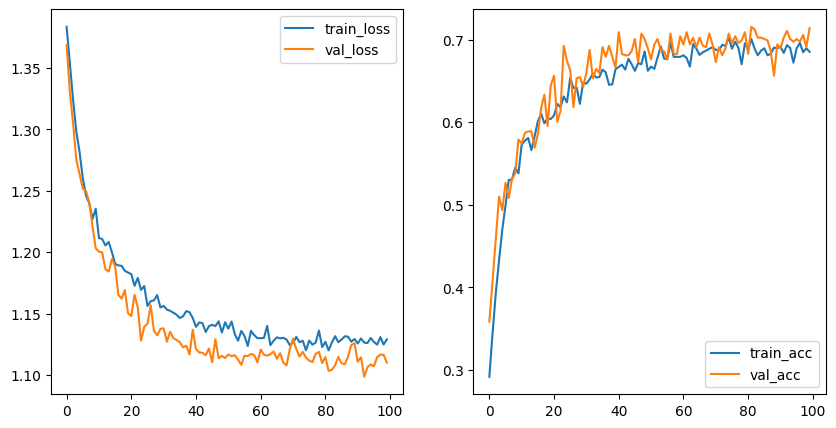

In [ ]:
import matplotlib.pyplot as plt

loss = history['train_loss']
acc = history['train_acc']
val_loss = history['val_loss']
val_acc = history['val_acc']

eps = range(len(val_loss))

fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(eps, loss, label = 'train_loss')
ax1.plot(eps, val_loss, label = 'val_loss')
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(eps, acc, label = 'train_acc')
ax2.plot(eps, val_acc, label = 'val_acc')
ax2.legend()
plt.show()

4.1 손실 평가
- 학습 및 검증 손실값의 차이가 크지 않음 : 과적합의 가능성이 낮음
- 검증값이 학습 값보다 낮은 구간이 존재 : 일반화 성능이 양호

4.2 정확도 평가
- 과적합이 없음
- epoch 30 이후 정확도가 0.6이상으로 안정화
- 검증 정확도가 70% 내외로 수렴 : 비교적 안정적인 성능